In [ ]:
import pandas as pd
import numpy as np

# 读取 npz 文件
data = np.load('./data/SWAT/train_swat.npz')
# ['train_x', 'train_target', 'val_x', 'val_target', 'mean', 'std']
data.files
# 获取 train_x 数组并查看其形状
# train_x = data['train_x']
# npy数据格式是一个四维的数组[N，H，W, C]，其中N代表数据集的总数，H, W，C分别代表每一张图片对应的长、宽、以及通道数。
# # Original train_x shape: (4195, 51, 1, 30)
# # print("Original train_x shape:", train_x.shape)


In [ ]:
train_x = data['train_x']
train_x.shape

In [ ]:
mean = data['mean']  # 获取均值
mean

In [ ]:
std = data['std']  # 获取标准差
std

In [ ]:
np.zeros((1, 1, 3, 1))

In [ ]:
num_samples, dim1, dim2, dim3 = train_x.shape
train_x[0, :, 0, 0]

In [ ]:
train_x[0, 0, :, 0]

In [ ]:
train_x[0, 0, 0, :]

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# 假设我们有一些输入数据 X 和标签 Y
X = torch.randn(100, 3)  # 100个样本，每个样本3个特征
Y = torch.randn(100, 1)  # 100个样本的标签

In [ ]:
# 创建 TensorDataset
dataset = TensorDataset(X, Y)
dataset

In [ ]:
# 创建 DataLoader
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
dataloader

In [ ]:
# 迭代 DataLoader
for i, (x, y) in enumerate(dataloader):
    print(f"Batch {i}:")
    print(f"Features: {x.size()}, Labels: {y.size()}")
    # 在这里，x 和 y 将是批次的特征和标签


In [ ]:
from torch.utils.tensorboard import SummaryWriter


In [1]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(10, 2)  # 这是一个简单的示例模型
     
    def forward(self, x):
        return self.fc(x)

model = MyModel()


In [3]:
# 加载模型参数
model_params_path = 'experiments/swat_test/epoch_299.params'
state_dict = torch.load(model_params_path)

# 将参数加载到模型中
model.load_state_dict(state_dict)

# 设置模型为评估模式（如果需要）
model.eval()


RuntimeError: Error(s) in loading state_dict for MyModel:
	Missing key(s) in state_dict: "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "graph_learner.mlp1.fc1.weight", "graph_learner.mlp1.fc1.bias", "graph_learner.mlp1.fc2.weight", "graph_learner.mlp1.fc2.bias", "graph_learner.mlp1.bn.weight", "graph_learner.mlp1.bn.bias", "graph_learner.mlp1.bn.running_mean", "graph_learner.mlp1.bn.running_var", "graph_learner.mlp1.bn.num_batches_tracked", "graph_learner.Wq.weight", "graph_learner.Wq.bias", "graph_learner.Wk.weight", "graph_learner.Wk.bias", "linear1.weight", "linear1.bias", "encoder_model.0.dcgru_layers.0._gconv_0.weight", "encoder_model.0.dcgru_layers.0._gconv_0.bias", "encoder_model.0.dcgru_layers.0._gconv_1.weight", "encoder_model.0.dcgru_layers.0._gconv_1.bias", "encoder_model.0.dcgru_layers.0._gconv_c_0.weight", "encoder_model.0.dcgru_layers.0._gconv_c_0.bias", "encoder_model.0.dcgru_layers.0._gconv_c_1.weight", "encoder_model.0.dcgru_layers.0._gconv_c_1.bias", "encoder_model.1.dcgru_layers.0._gconv_0.weight", "encoder_model.1.dcgru_layers.0._gconv_0.bias", "encoder_model.1.dcgru_layers.0._gconv_1.weight", "encoder_model.1.dcgru_layers.0._gconv_1.bias", "encoder_model.1.dcgru_layers.0._gconv_c_0.weight", "encoder_model.1.dcgru_layers.0._gconv_c_0.bias", "encoder_model.1.dcgru_layers.0._gconv_c_1.weight", "encoder_model.1.dcgru_layers.0._gconv_c_1.bias", "encoder_model.2.dcgru_layers.0._gconv_0.weight", "encoder_model.2.dcgru_layers.0._gconv_0.bias", "encoder_model.2.dcgru_layers.0._gconv_1.weight", "encoder_model.2.dcgru_layers.0._gconv_1.bias", "encoder_model.2.dcgru_layers.0._gconv_c_0.weight", "encoder_model.2.dcgru_layers.0._gconv_c_0.bias", "encoder_model.2.dcgru_layers.0._gconv_c_1.weight", "encoder_model.2.dcgru_layers.0._gconv_c_1.bias", "linear_out.weight", "linear_out.bias". 

In [ ]:
for name, param in model.named_parameters():
    print(f"Parameter {name}: {param}")


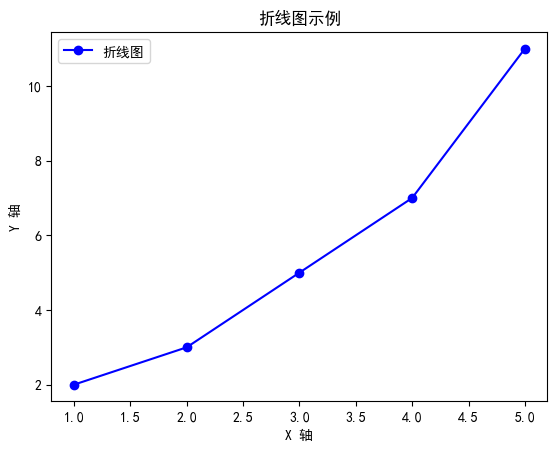

In [4]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']     # 显示中文
# 为了坐标轴负号正常显示。matplotlib默认不支持中文，设置中文字体后，负号会显示异常。需要手动将坐标轴负号设为False才能正常显示负号。
matplotlib.rcParams['axes.unicode_minus'] = False

# 数据
x = [1, 2, 3, 4, 5]
y = [2, 3, 5, 7, 11]

# 绘制折线图
plt.plot(x, y, marker='o', linestyle='-', color='b', label='折线图')

# 设置标题和标签
plt.title('折线图示例')
plt.xlabel('X 轴')
plt.ylabel('Y 轴')

# 显示图例
plt.legend()

# 显示图形
plt.show()
